In [34]:
%load_ext cudf.pandas
import pandas as pd

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [35]:
import sys
sys.path.append("..")
import cupyx.scipy.stats as cstats
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from src.data_processing import *
sns.set_style("whitegrid")
sns.set_palette("deep")
sns.set(rc={'figure.figsize':(8,6)})

# 1. Import data and inspections

In [36]:
DATA_PATH = '../data/immo_data.csv'
apartment_df = pd.read_csv(DATA_PATH, header=0)

## 1.1 An overview on the dataset

The explanation of the each column can be found here: https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany/data

Total rent (usually a sum of base rent, service charge and heating cost). So, `serviceCharge` will **overlap** with the *Internet and TV services*

In [37]:
apartment_df.describe(datetime_is_numeric=True)

,serviceCharge,telekomHybridUploadSpeed,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
count,261941.000000,45020.0,268850.000000,267018.000000,235492.000000,2.283330e+05,211805.000000,2.688500e+05,93052.000000,211805.000000,2.688500e+05,268850.000000,268850.000000,268850.000000,268850.000000,162344.000000,217541.000000,171118.000000,268850.000000,268850.000000,85518.000000,80711.000000,46846.000000,46846.000000
mean,151.206113,10.0,9.791958,3.389001,28.804928,9.013315e+02,1966.400590,1.069697e+08,1.327634,3.714544,6.941294e+02,74.355548,3.765256,37283.022235,2.641261,114.749533,2.122405,3.572319,2.571542,3.070790,76.990866,2013.904536,89.113612,0.199769
std,308.295790,0.0,6.408399,1.964874,16.337151,3.323833e+04,46.992207,1.250093e+07,8.361403,2.738134,1.953602e+04,254.759208,2.214357,27798.037296,2.633440,61.653663,3.634934,6.375496,0.937594,1.407127,147.716278,10.963125,5.395805,0.009667
min,0.000000,10.0,0.000000,-12.330000,1.000000,0.000000e+00,1000.000000,2.887174e+07,0.000000,1.000000,0.000000e+00,0.000000,1.000000,852.000000,1.000000,0.100000,-1.000000,0.000000,1.000000,1.000000,0.000000,1015.000000,71.430000,0.170500
25%,95.000000,10.0,6.000000,2.000000,10.000000,4.698000e+02,1950.000000,1.066910e+08,1.000000,1.000000,3.380000e+02,54.000000,2.000000,9128.000000,2.000000,79.000000,1.000000,2.000000,2.000000,2.000000,54.000000,2012.000000,90.760000,0.191500
50%,135.000000,10.0,9.000000,3.390000,40.000000,6.500000e+02,1973.000000,1.111584e+08,1.000000,3.000000,4.900000e+02,67.320000,3.000000,38667.000000,3.000000,107.000000,2.000000,3.000000,3.000000,3.000000,70.000000,2017.000000,90.760000,0.198500
75%,190.000000,10.0,13.000000,4.570000,40.000000,9.850000e+02,1996.000000,1.137688e+08,1.000000,5.000000,7.990000e+02,87.000000,5.000000,57072.000000,3.000000,140.300000,3.000000,4.000000,3.000000,4.000000,90.000000,2019.000000,90.760000,0.205500
max,146118.000000,10.0,121.000000,14.920000,100.000000,1.575154e+07,2090.000000,1.157117e+08,2241.000000,9.000000,9.999999e+06,111111.000000,9.000000,99998.000000,999.990000,1996.000000,999.000000,999.000000,5.000000,7.000000,12613.000000,2919.000000,90.760000,0.227600


In [38]:
print(f"The number of feature are: {apartment_df.shape[1]} \n\
The number of example are: {apartment_df.shape[0]}")

The number of feature are: 49 
The number of example are: 268850


In [39]:
md(f"The list of features:\n\n {apartment_df.columns.to_list()}")

The list of features:

 ['regio1', 'serviceCharge', 'heatingType', 'telekomTvOffer', 'telekomHybridUploadSpeed', 'newlyConst', 'balcony', 'picturecount', 'pricetrend', 'telekomUploadSpeed', 'totalRent', 'yearConstructed', 'scoutId', 'noParkSpaces', 'firingTypes', 'hasKitchen', 'geo_bln', 'cellar', 'yearConstructedRange', 'baseRent', 'houseNumber', 'livingSpace', 'geo_krs', 'condition', 'interiorQual', 'petsAllowed', 'street', 'streetPlain', 'lift', 'baseRentRange', 'typeOfFlat', 'geo_plz', 'noRooms', 'thermalChar', 'floor', 'numberOfFloors', 'noRoomsRange', 'garden', 'livingSpaceRange', 'regio2', 'regio3', 'description', 'facilities', 'heatingCosts', 'energyEfficiencyClass', 'lastRefurbish', 'electricityBasePrice', 'electricityKwhPrice', 'date']

## 1.2. Data cleaning

* Since the data is scraped from immobilienscout24.de, each listing is identified by an unique ID number, presented in `scoutId` column. Hence, to check duplications of the data, all the duplications in `scoutId` is dropped.

In [40]:
# Use listing ID (`scoutId`) to check for dupplicated values
apartment_df = apartment_df.drop_duplicates(subset='scoutId')

After reviewing the explaination of each columns, the repeated information should be dropped.
The table below shows the dropped columns that have dupplicated infomation:

|Table name | Description | Note |
| --------- | ----------- | ---- |
|scoutId | | not needed anymore|
|date | date of scrapping data | not relevant|
|regio1 | replace with `distance` in feature engineering section | |
|regio2 | replace with `distance` in feature engineering section | |
|regio3 | replace with `distance` in feature engineering section | |
|geo_bln | bundesland (state), same as regio1 | duplicated|
|geo_krs | District or Kreis, same as regio2 | duplicated|
|street | too specific and may not generalize well | duplicated |
|streetPlain | too specific and may not generalize well| duplicated |
|houseNumber | too specific and may not generalize well| duplicated |
| thermalChar | it is deprecated | |
| telekomUploadSpeed| too specific and may not generalize well| |
| telekomHybridUploadSpeed| too specific and may not generalize well| |
| telekomTvOffer| `serviceCharge` cover this info| duplicated|
| energyEfficiencyClass| `serviceCharge` cover this info| duplicated|
| electricityBasePrice| `serviceCharge` cover this info | duplicated|
| electricityKwhPrice| `serviceCharge` cover this info |duplicated|
| livingSpaceRange| a diff. format of `livingSpace`|duplicated|
| noRoomsRange|a diff. format of `noRooms`|duplicated|
| baseRentRange |a diff. format of`baseRent` |duplicated|
| yearConstructedRange |a diff. format of `yearConstructed` |duplicated|
| newlyConst| a diff. format of `yearConstructed` |duplicated|

In [41]:
delete_cols = ['scoutId', 'date', 'regio1', 'regio3','geo_bln', 'geo_krs', 'street', 'streetPlain',
            'houseNumber','thermalChar','telekomUploadSpeed', 'telekomHybridUploadSpeed','telekomTvOffer',
            'energyEfficiencyClass','electricityBasePrice','electricityKwhPrice','livingSpaceRange',
            'noRoomsRange','baseRentRange','yearConstructedRange', 'newlyConst']

apartment_df = apartment_df.drop(delete_cols, axis=1)

* For the first part of the solution, two textual data columns are not considered, hence, they're dropped

In [42]:
apartment_df = apartment_df.drop(['description', 'facilities'], axis=1)

* Checking the missing values of each feature. List the number of missing values in each columns.

In [43]:
report = count_missing_values(apartment_df)
report

,Missing count,Percentage
lastRefurbish,188139,69.979171
heatingCosts,183332,68.191185
noParkSpaces,175798,65.388879
petsAllowed,114573,42.615957
interiorQual,112665,41.906267
numberOfFloors,97732,36.351869
condition,68489,25.474800
yearConstructed,57045,21.218151
firingTypes,56964,21.188023
floor,51309,19.084620


* It's evident that there plenty of columns that have high amount of missing data, and filling missing values techniues will be not effective with too high level of missing. Hence, dropping all columns with missing percentage > **35%**

In [44]:
# Drop columns with missing values above threshold
threshold = 35
cols_to_drop = report[report['Percentage'] > threshold].index.to_list()
print(f'The {len(cols_to_drop)} dropped columns are:\n', cols_to_drop)
apartment_df = apartment_df.drop(cols_to_drop, axis=1)

The 6 dropped columns are:
 ['lastRefurbish', 'heatingCosts', 'noParkSpaces', 'petsAllowed', 'interiorQual', 'numberOfFloors']


In [45]:
print(f'The {len(apartment_df.columns)} remaining columns are:')
print(f"{apartment_df.columns.to_list()}")

The 20 remaining columns are:
['serviceCharge', 'heatingType', 'balcony', 'picturecount', 'pricetrend', 'totalRent', 'yearConstructed', 'firingTypes', 'hasKitchen', 'cellar', 'baseRent', 'livingSpace', 'condition', 'lift', 'typeOfFlat', 'geo_plz', 'noRooms', 'floor', 'garden', 'regio2']


## 1.3. Features engineering

### 1.3.1 Convert all location data to the distance from them to **Stuttgart** (48.7758° N, 9.1829° E)

The location is importance features for predicting rental prices. These features can provide valuable spatial information that may contribute to the model's predictive power. This dataset has 6 columns related to location, which can greately reduce to one column `distance`.\
The distance to a specific location is measurable, numeric, and distinct, will works nicely for regression model. Stuttgart is chosen for reference point.


The data for coordinates is from: https://gist.github.com/iteufel/af379872bbc3bf5261e2fd09b681ff7e.\
Then, it is converted to csv using function `sql2csv` in `src/data_processing.py`

In [46]:
zip_coordinates = pd.read_csv('../data/zip_coordinates.csv', header=0)

Matching the zipcodes with col. `geo_plz`, then add the corresponding latitude and longitude coordinate.

In [47]:
merged_df = pd.merge_asof(apartment_df.sort_values('geo_plz'),
                               zip_coordinates[['zipcode','lat', 'lon']].sort_values('zipcode'),
                               left_on='geo_plz', right_on='zipcode',
                               direction='nearest')

In [48]:
# Verifying the results
verification_result = merged_df['geo_plz'] == merged_df['zipcode']

# Count the number of discrepancies
num_discrepancies = verification_result.value_counts()
percent = 100 * (num_discrepancies[False] / merged_df.shape[0])
# Display the verification result
print("Verification Result:")
print(f"Matched: {num_discrepancies[True]}")
print(f"Mismatched: {num_discrepancies[False]} ({percent:2f} %)")

Verification Result:
Matched: 267525
Mismatched: 1325 (0.492840 %)


* The mismatched is only about $0.5 \%$, so far so good. Compute the distance from Stuttgart ($48.7758° N, 9.1829° E$) for all the rows.

In [49]:
# Reference coordinates for Stuttgart
ref_lat = 48.7758
ref_lon = 9.1829
# Create a new column 'distance' using the haversine_distance_cudf function
merged_df['distance'] = haversine_distance(merged_df['lat'],
                                                merged_df['lon'],
                                                ref_lat, ref_lon)

In [50]:
merged_df['distance'].describe()

count    268850.000000
mean        332.449915
std         133.981287
min           0.842192
25%         265.568757
50%         342.334535
75%         406.065157
max         716.405714
Name: distance, dtype: float64

The statistics is appropriatley and make sense: $min >0$, $std = 133$

[Text(0.5, 0, 'Distance'),
 Text(0, 0.5, 'Number of listing'),
 Text(0.5, 1.0, 'Distance from rental properties to Stuttgart [Km]')]

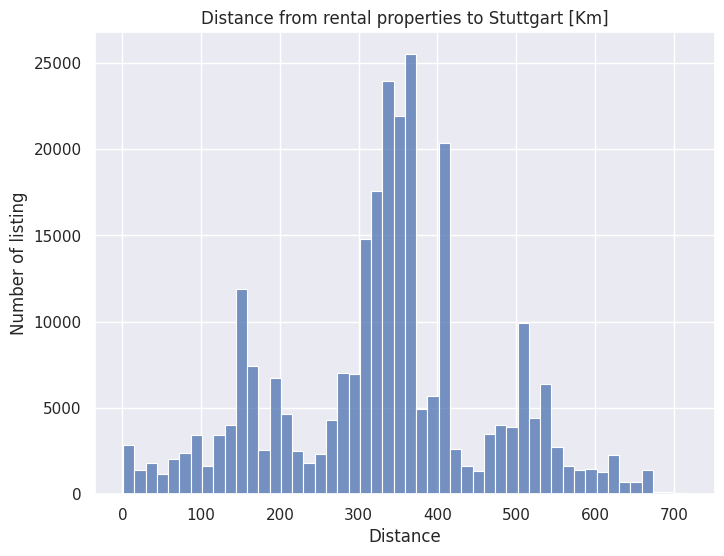

In [51]:

ax = sns.histplot(merged_df, x='distance', bins=50)
ax.set(
    xlabel="Distance",
    ylabel="Number of listing",
    title="Distance from rental properties to Stuttgart [Km]",
)

Now, distance will present the influence of locations, drop all other location related colmns

In [52]:
merged_df = merged_df.drop(['geo_plz','zipcode', 'lat', 'lon'], axis=1)

### 1.3.2 Fill `totalRent` data with `baseRent` and `serviceCharge`

In [53]:
df = merged_df.dropna(subset=['totalRent', 'baseRent', 'serviceCharge'])

In [54]:
df['baseRent'].describe()

count    224243.000000
mean        642.056936
std         505.543726
min           0.000000
25%         333.000000
50%         486.720000
75%         793.515000
max       30990.000000
Name: baseRent, dtype: float64

In [55]:
df['serviceCharge'].describe()

count    224243.000000
mean        151.423054
std         326.320957
min           0.000000
25%          95.480000
50%         136.000000
75%         190.000000
max      146118.000000
Name: serviceCharge, dtype: float64

In [56]:
df['totalRent'].describe()

count    2.242430e+05
mean     8.921350e+02
std      3.337203e+04
min      0.000000e+00
25%      4.690000e+02
50%      6.481300e+02
75%      9.800000e+02
max      1.575154e+07
Name: totalRent, dtype: float64

In [57]:
residude = df['totalRent'] - df['baseRent'] - df['serviceCharge']
residude.describe()

count    2.242430e+05
mean     9.865496e+01
std      3.336720e+04
min     -1.459720e+05
25%      0.000000e+00
50%      0.000000e+00
75%      4.200000e+01
max      1.574996e+07
dtype: float64

# 2. Detecting outliers by employing Leys et al. (2013)
## 2.1 Fundamentals
Detecting outliers by determining an interval spanning over the mean plus/minus three standard deviations (or z-score < $\pm 3$) remains a common practice. However, since both the mean and the standard deviation are particularly **sensitive** to outliers, this method is problematic.

 Leys et al. (2013) recommended to use absolute deviation around the median, which is a more robust measure of dispersion.
All the numeric columns are cleaned from outliers with criteria using the median absolute deviation (MAD). The process is as follows:
 1. Compute the MAD taking the median of the absolute deviations from the data's median, i.e:
        $$ \mathrm{MAD} = \frac{1}{Q(0.75)} * \mathrm{med}\big(\vert x_i - \mathrm{med}(\mathbf{x}) \vert \big) \quad i=1,\dots,n \, ,$$
    where $Q(0.75)$: the 0.75 quantile of that underlying distribution; $\mathrm{med}(\mathbf{x})$: the median of set $\mathbf{x}$ consiting of $n$ elements; $x_i$: the $i^{th}$ component of $\mathbf{x}$.
 2. Define a threshold $k$ for the rejection criterion:
    $$ \mathrm{med}(\mathbf{x}) - k * \mathrm{MAD} < x_i < \mathrm{med}(\mathbf{x}) + k * \mathrm{MAD}$$
    where $k$ is subjective choice and under debate.

Leys recomned $k=\pm2.5$, but needed to carefully justified case by case. Also, the number of outliers removed and their value must be reported.

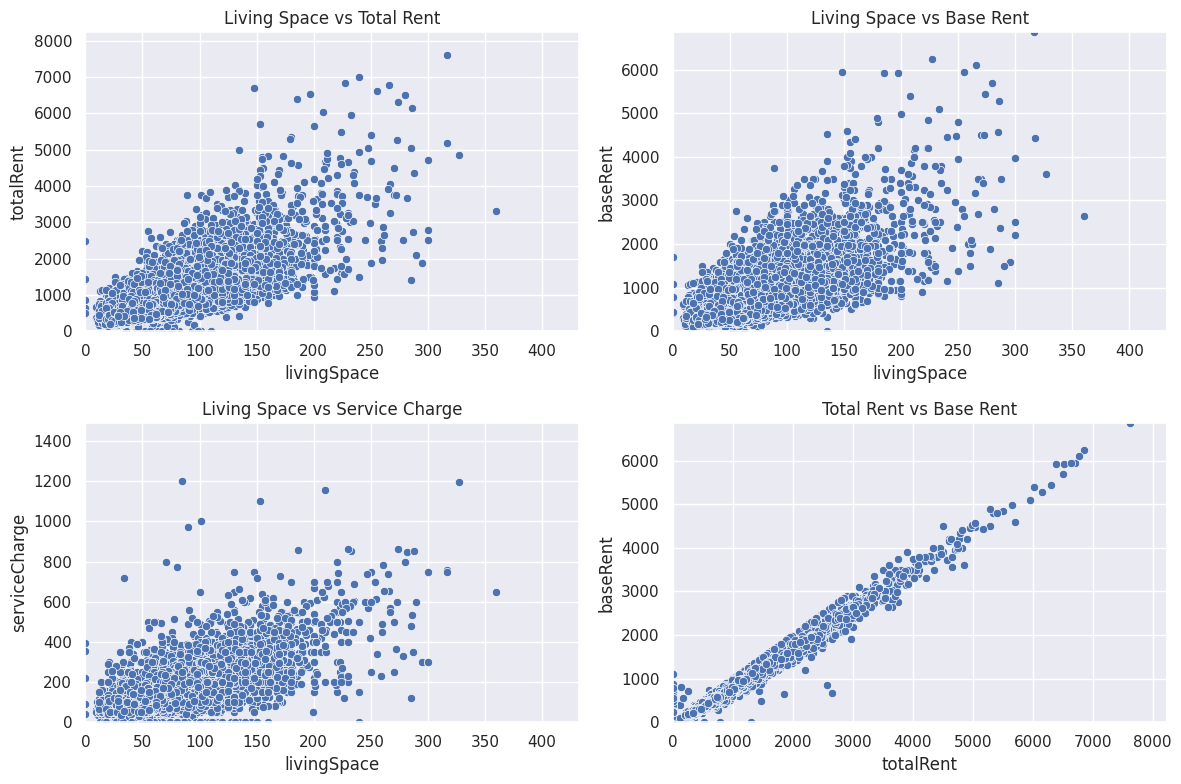

In [58]:
df = merged_df[['totalRent', 'baseRent','serviceCharge', 'livingSpace']]
df = df[df.notnull().all(1)]
df = df.sample(frac=0.1)

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Define a function to create a scatter plot
def scatter_plot(df, x, y, title, ax):
    sns.scatterplot(data=df, x=x, y=y, ax=ax)
    ax.set_title(title)
    ax.set_xlim([0, df[x].quantile(.9999)])
    ax.set_ylim([0, df[y].quantile(.9999)])

# Create the scatter plots
scatter_plot(df, 'livingSpace', 'totalRent', 'Living Space vs Total Rent', axes[0, 0])
scatter_plot(df, 'livingSpace', 'baseRent', 'Living Space vs Base Rent', axes[0, 1])
scatter_plot(df, 'livingSpace', 'serviceCharge', 'Living Space vs Service Charge', axes[1, 0])
scatter_plot(df, 'totalRent', 'baseRent', 'Total Rent vs Base Rent', axes[1, 1])

plt.tight_layout()

* Top left plot shows there are unreasonable values of `livingSpace` and `totalRent`. Plenty of `livingSpace`'s values near zeros or more than 350 $m^2$. Similarly for `totalRent` case, extreme values near zeros and very large values as $11 000$ euros/month.
* Lower left graph show the same problems for `serviceCharge`
* There are strong colinearlity of `totalRent` and `baseRent`, it makes sense since `totalRent` ~ `baseRent` + `serviceCharge`. However, there are some exeptions that needed to be filtered.

In [59]:

# def hist_plot(df, x, title, ax, log_scale=False):
    
#     ax.set_title(title)
#     if log_scale:
#         x = cp.log1p(df[x]) # for performance purpose

#     sns.histplot(data=df, x=x, log_scale=log_scale, ax=ax)

    
# # Create a figure and a set of subplots
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# hist_plot(df,'totalRent', 'Raw values of `totalRent`', axes[0, 0])
# hist_plot(df,'totalRent', 'Log scale of `totalRent`', axes[0, 1], log_scale=True)

# hist_plot(df,'livingSpace', 'Raw values of `livingSpace`', axes[1, 0])
# hist_plot(df,'livingSpace', 'Log scale of `livingSpace`', axes[1, 1], log_scale=True)

# plt.tight_layout()

The graphs above show the data are skew seriouly. When transforming the data to $\log$-scale, they are closer to the normal distribution. This properties of this dataset in $\log$-space will be employed for the effectiveness of outlier detection and buil machine learning model.

* Show the skewness of data:

|Sknewness| Note|
| ------- | --- |
|[-0.5, 0.5] | fairly symmetrical|
|[-1.0, -0.5]  | moderately right skewed|
|[0.5, 1.0]  | moderately left skewed|
|-1< or > 1 | highly skewed|


## 2.2 Outliers detection process
Since the method (Leys et al. (2023))does not mention about the treatments of catalogue data type, therfore, only numeric data are concerned. Also, for this work, normal distribution type is refered. The outlier cleaning process are as follows:
 1. Numeric columns with `non-NAN` values are cloned for the outliers clean process.
 2. Transform the highly skewed columns into log-space, determine, and store outliers' indices.
 2. Store the idices of ouliers for each numeric column.
 3. Drop all rows containing the outliers of the original dataframe using the stored indices. 

**Remark**: Logarithmic transformation push a skewed distribibution closer to the *normal distribution*. When applied to a positively skewed distribution (where the majority of data points are on the left side and the tail extends to the right), the log transformation tends to compress the larger values and spread out the smaller values. This has the effect of making the distribution more symmetric and closer to a normal distribution.

In [106]:
# Get all numeric columns and assign to temp dataframe
numeric_df = merged_df.select_dtypes(include=['number'])

In [107]:
# column `floor` have min. val. < 0, which cannot apply $log$-scale.
# Modify
numeric_df['floor'] = numeric_df['floor'] + 1.0

In [108]:
numeric_df.skew(axis=0, skipna=True).sort_values(ascending=False)

baseRent           500.201947
totalRent          466.567542
serviceCharge      409.164323
livingSpace        373.839260
noRooms            249.536282
floor              155.438057
picturecount         1.808686
pricetrend           0.383556
distance            -0.128772
yearConstructed     -4.564780
dtype: float64

All heavily skewed columns should be transformed

In [109]:
# Initialize a dictionary to store the bounds and outlier indices
bounds_and_outliers = {}

scale_col = ['baseRent', 'totalRent','serviceCharge','livingSpace', 'noRooms', 'floor']

# Manually choose k by reviewing the results of the bounds is needed to make sure
# it is appropriate for the dataset
threshold = [[3,3], [3,3.5], [3, 3.5], [5., 4.], [3., 3.], [4,3.]]


for col, k in zip(scale_col, threshold):
    # Drop NaN values
    clean_col = numeric_df[col][numeric_df[col].notna()]
    # Check values before applying log-scale transformation
    assert clean_col.min() >= 0
    # Transform to log-scale
    log_col = cp.log1p(clean_col)    

    # Get the boundary of ouliers
    lower_, upper_  = compute_mad_1d(log_col, k)
    upper, lower = cp.expm1(upper_), cp.expm1(lower_)

    print('='*40)
    print(f'Corrected range for {col}:')
    print(f'{lower:2f} < {col} < {upper:2f}')
    print(f'Number of outliers (lower): {clean_col[clean_col < lower].shape[0]}')
    print(f'Number of outliers (upper): {clean_col[clean_col > upper].shape[0]}')
    # Find the outliers
    outliers = numeric_df[(numeric_df[col] < lower) | (numeric_df[col] > upper)]
    numeric_df = numeric_df.drop(outliers.index)
    print("Shape", numeric_df.shape[0])

Corrected range for baseRent:
72.844804 < baseRent < 3263.698197
Number of outliers (lower): 176
Number of outliers (upper): 1133
Shape 267541
Corrected range for totalRent:
127.564682 < totalRent < 4289.964129
Number of outliers (lower): 286
Number of outliers (upper): 16
Shape 267239
Corrected range for serviceCharge:
28.923240 < serviceCharge < 794.531882
Number of outliers (lower): 3872
Number of outliers (upper): 82
Shape 263285
Corrected range for livingSpace:
11.603145 < livingSpace < 264.235472
Number of outliers (lower): 192
Number of outliers (upper): 155
Shape 262938
Corrected range for noRooms:
0.479228 < noRooms < 9.816452
Number of outliers (lower): 0
Number of outliers (upper): 37
Shape 262901
Corrected range for floor:
-0.276524 < floor < 13.422378
Number of outliers (lower): 0
Number of outliers (upper): 441
Shape 262460


In [113]:
list_outlier_idx = merged_df.select_dtypes(include=['number']).index.difference(numeric_df.index).tolist()
print(f"Total ouliers dectected: {len(list_outlier_idx)}")
outliers_percent = 100 * (len(list_outlier_idx) / merged_df.shape[0])
print(f'Percentage of outliers: {outliers_percent:3f} %')

Total ouliers dectected: 6390
Percentage of outliers: 2.376790 %


Drop all the outliers

In [114]:
merged_df = merged_df.drop(list_outlier_idx)

Verifying the skewness of cleaned data

In [115]:
merged_df.select_dtypes(include=['number']).skew(axis=0, skipna=True).sort_values(ascending=False)

baseRent           1.976336
totalRent          1.921180
picturecount       1.830772
serviceCharge      1.511638
floor              1.367218
livingSpace        1.293752
noRooms            0.543556
pricetrend         0.393523
distance          -0.130470
yearConstructed   -4.600339
dtype: float64

In [116]:
count_missing_values(merged_df.select_dtypes(include=['number']))

,Missing count,Percentage
yearConstructed,55556,21.167416
floor,49544,18.876781
totalRent,39915,15.208032
serviceCharge,6672,2.542102
pricetrend,1809,0.689248
picturecount,0,0.000000
baseRent,0,0.000000
livingSpace,0,0.000000
noRooms,0,0.000000
distance,0,0.000000
